# Image Deblurring - 06/22 - Simone Mele

Create a deblurring deep learning model, aimed to remove gaussian blur and gaussian noise from images.\
Given a blurred image $x$, reconstruct the original deblurred image $y$.

The problem can be reformulated in the following way: given a 3D signal
\begin{align}
x(u) = (h * y) (u) + \eta(u)
\end{align}
our goal is to obtain an estimation $\hat{y}$ that minimizes the mean square error
\begin{align}
\mathbb{E} \|y(u)-\hat{y}(u)\|^2
\end{align}
where $*$ denotes convolution, $h(u)$ is the gaussian blur filter, and $\eta(u)$ is the gaussian noise.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as ks
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision

from keras.utils.layer_utils import count_params

# Make the model run faster and use less memory during training
mixed_precision.set_global_policy('mixed_float16')
K.set_floatx('float16')

def count_trainable_params(model):
    return count_params(model.trainable_weights)

## Dataset creation

In [2]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
    (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
    normalize = lambda x: x/x.max()
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
    return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [3]:
# Store the dataset so I can use always the same generated data across different models
dataset_path = 'data.pickle'
if not os.path.exists(dataset_path):
    dataset = getDataset()
    with open('data.pickle', 'wb') as file:
        pickle.dump(dataset, file)

In [3]:
with open(dataset_path, 'rb') as file:
    (x_train, y_train), (x_test, y_test) = pickle.load(file)

print(x_train.dtype)
# Reduce the amount of memory needed during learning
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

print('Train shape:', x_train.shape)
print('Test shape: ', x_test.shape)

print('Mean:', x_train.mean())
print('Std:', x_train.std())
print('Min:', x_train.min())
print('Max:', x_train.max())

float64
Train shape: (50000, 32, 32, 3)
Test shape:  (10000, 32, 32, 3)
Mean: 0.47290814
Std: 0.22588024
Min: -0.086320095
Max: 1.0884542


### Visualize data

As we may expect, because of the blurring filter, the high frequency content is lost.

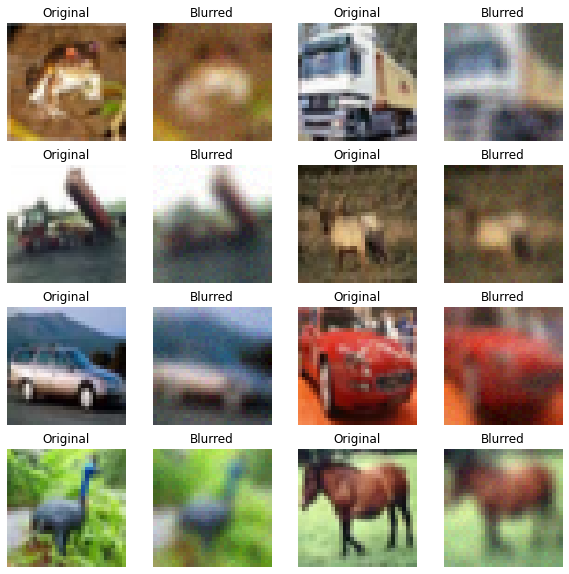

In [10]:
def plot_images(imgs, titles, n_images = 8, figsize=(10,10)):
    imgs_per_rows = 1
    cols = len(imgs)
    if cols <= 2:
        imgs_per_rows = 4 // cols
    
    imgs = [img[:n_images].clip(0,1).astype('float64') for img in imgs]
    
    plt.figure(figsize=figsize)
    for i in range(n_images):
        for j in range(cols):
            ax = plt.subplot(n_images // imgs_per_rows, imgs_per_rows * cols, cols*i + j+1)
            plt.imshow(imgs[j][i])
            plt.title(titles[j])
            plt.axis("off")
            
plot_images([y_train, x_train], ['Original', 'Blurred'])

### Metrics
MSE is the metric chosen for the problem. Another important metric, always used in the literature, is the PSNR. Therefore, both metrics will be provided in next sections. 

In [4]:
def mse(y, y_pred):
    m = ks.metrics.MeanSquaredError()
    m.update_state(y, y_pred)
    return m.result().numpy()

def psnr(original, noisy):
    return cv2.PSNR(original * 255, noisy * 255)

def compute_metrics(original, noisy, metrics):
    results = {}
    for name, metric in metrics.items():
        results[name] = metric(original, noisy)
    return results

# used in the training process
metric = 'mse'
        
metrics = {'MSE': mse, 'PSNR (dB)': psnr}
score = compute_metrics(y_train, x_train, metrics)
print(score)

{'MSE': 0.006737797, 'PSNR (dB)': 21.714820758801533}


## Convolutional Neural Networks

The reasons why the use of convolutional neural networks seems interesting are:
1. inputs and outputs of the problem are both images
2. from the mathematical point of view, the problem can be solved by finding a function $g$ s.t. $x(u) = (g*y)(u)$, e.g. by using a Wiener deconvolution [[1]](https://en.wikipedia.org/wiki/Wiener_deconvolution)
3. until a couple of years ago, CNNs were the state of the art for image restoration

Therefore the idea is to build a FCNN which is able to extract local and global features from the blurred image in order to restore the original one.

#### UNet
The first architecture that came to my mind, and also the most promising one according to the experimental results, is Unet. It was designed for segmentation task, but by chaning the loss function and the last convolutional layer, it can be used also for this purpose.

##### Output Layer
In the default UNet architecture, output layer is a convolutional layer, which produces a single feature map and makes use of sigmoid. In our problem, we need to restore the whole image, therefore the output layer must have three output channels. Also, since each pixel does not represent a probability (i.e. we don't want the brightness to be as much as possible 0 or 1), a thresholding function such as the sigmoid is meaningless. In particular, no activation function has been used.

##### Loss
For what I said before, the task can be seen as a regression task, where the output is a matrix with float values in the range [0,1]. Therefore a regression loss function should be used. According to literature [[2]](https://arxiv.org/pdf/1511.08861.pdf), MAE gives better results for the human visual system than MSE, therefore the former has been chosen.

In [5]:
# Repeat the provided layer n_layers times
class RepeatBlock(ks.layers.Layer):
    def __init__(self, layer_generator, n_layers, **kwargs):
        super().__init__(**kwargs)

        self.layers = [layer_generator() for i in range(n_layers)]

    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'layer_generator': self.layer_generator,
            'n_layers':self.n_layers
        })
        return config

class Unet(ks.Model):
    def __init__(self, out_ch, filters=64, kernel_size=(3, 3), n_layers=4, conv_per_layer=2, activation='relu', **kwargs):
        super().__init__(**kwargs)
        
        self.out_ch = out_ch
        self.filters = filters
        self.kernel_size = kernel_size
        self.n_layers = n_layers
        self.conv_per_layer = conv_per_layer
        self.activation = activation
        
        conv_generator = lambda filters: lambda: ks.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same')
        #down
        self.down_list = []
        for l in range(n_layers):
            conv_block = RepeatBlock(conv_generator(filters), conv_per_layer, name=f"down_conv_{filters}_block")
            pooling = ks.layers.MaxPool2D(pool_size=(2, 2), padding='same')
            self.down_list.append((conv_block, pooling))
            filters *= 2
            
        self.intermediate_conv_block = RepeatBlock(conv_generator(filters), conv_per_layer, name=f"conv_{filters}_block")

        #up
        self.up_list = []
        for l in range(n_layers):
            filters = filters // 2
            deconv = ks.layers.Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=2)
            conv_block = RepeatBlock(conv_generator(filters), conv_per_layer, name=f"up_conv_{filters}_block")
            self.up_list.append((deconv, conv_block))

        self.out = ks.layers.Conv2D(filters=out_ch, kernel_size=(1, 1))

    def call(self, inputs):
        x = inputs
        down_layers = []
        for conv_block, pooling in self.down_list:
            conv = conv_block(x)
            x = pooling(conv)
            down_layers.append(conv)

        x = self.intermediate_conv_block(x)

        for deconv, conv_block in self.up_list:
            up = deconv(x)
            down = down_layers.pop()
            x = ks.layers.concatenate([down, up])
            x = conv_block(x)

        return self.out(x)

    def get_config(self):
        return {
            'out_ch': self.out_ch,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'n_layers': self.n_layers,
            'conv_per_layer': self.conv_per_layer,
            'activation': self.activation,
        }

def create_unet(filters=64, n_layers=3, activation='relu'):
    tf.keras.backend.clear_session()
     
    input_shape = x_train.shape[1:]
    img_ch = x_train.shape[-1]
    
    x = ks.layers.Input((None, None, img_ch))
    y = Unet(img_ch, filters=filters, n_layers=n_layers, activation=activation, name='unet')(x)
    model = ks.Model(x,y)
    return model

In [6]:
model = create_unet(filters=32, n_layers=4, activation='relu')


print(count_trainable_params(model))
model.summary()
model.get_layer('unet').summary()

7760163
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 unet (Unet)                 (None, None, None, 3)     7760163   
                                                                 
Total params: 7,760,163
Trainable params: 7,760,163
Non-trainable params: 0
_________________________________________________________________
Model: "unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 down_conv_32_block (RepeatB  multiple                 10144     
 lock)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                           

### Training

Several callbacks has been used:
- EarlyStopping stops when the val_mes doesn't improve for 15 steps, so to avoid overfitting
- ReduceLROnPlateau reduces the learning rate when the loss doesn't improve anymore, improving results
- BackupAndRestore allows to "pause" a training and to resume it in a different moment. It has been useful during the evaluation of different models
- ModelCheckpoint: automatically saves best weights

In [9]:
working_dir = 'unet'
loss = 'mae'
lr = 1e-3
epochs = 100
batch_size = 64
monitor = f'val_{metric}'

early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=15, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')

# ModelCheckpoint
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

# Backup and restore (useful to continue training in a different moment, since sometimes my GPU exhausts memory)
backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback,
    backup_callback,
    model_checkpoint_callback,
]

optimizer = ks.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_split=0.1,
                    epochs=epochs,
                    callbacks=callbacks)

### Training results

As we can see from the plot, after 15-20 epochs, the model tends to overfit.

In [1]:
def plot_history(history, metric='loss'):
    training = history.history[metric]
    val = history.history[f'val_{metric}']

    # Loss
    plt.plot(training)
    plt.plot(val)
    plt.grid()
    plt.title(f'{metric.capitalize()} during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

plot_history(history, 'loss')
plot_history(history, metric)

### Data Augmentation

Data augmentation improves result by reducing overfitting.
Since the shape, position and rotation of the image are important, each transformation to $x$ must be applied also to $y$.

The transformations added are vertical/horizontal flip and rotation by $a*90°$, where $a \in \{0, 1, 2, 3\}$

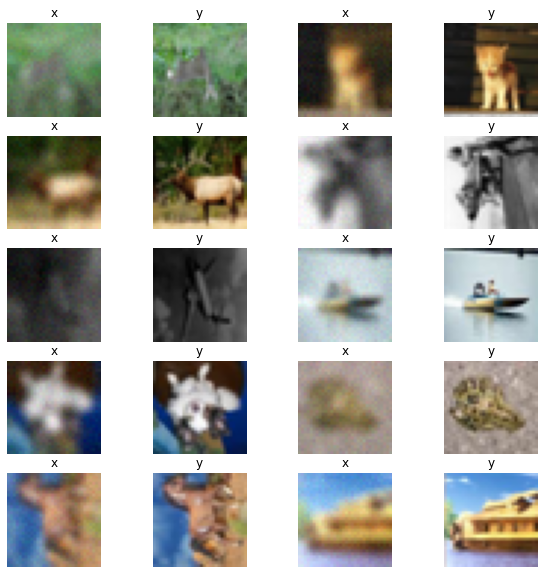

In [12]:
@tf.function
def vertical_flip(x, y):
    x = tf.image.flip_up_down(x)
    y = tf.image.flip_up_down(y)
    return x, y

@tf.function
def horizontal_flip(x, y):
    x = tf.image.flip_left_right(x)
    y = tf.image.flip_left_right(y)
    return x, y

@tf.function
def rotate(x, y, factor=0.1):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, random_angle)
    y = tf.image.rot90(y, random_angle)
    return x, y
    

def tf_data_generator(X, y, batch_size, augmentations=[]):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X))
    
    if len(augmentations) > 0:
        for f in augmentations:
            dataset = dataset.map(f, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = (dataset.repeat()
            .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))
    else:
        dataset = (dataset
            .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False, drop_remainder=False)
            .prefetch(tf.data.AUTOTUNE))
        
    return dataset


n_images = 10
augmented_ds =  tf_data_generator(x_train, y_train, n_images*3, augmentations=[horizontal_flip, vertical_flip, rotate])
    
for x,y in augmented_ds.take(1):
    plot_images([x.numpy(),y.numpy()], ['x', 'y'], n_images, figsize=(10, 10))

In [13]:
batch_size = 64

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

train_ds = tf_data_generator(x_train, y_train, batch_size, augmentations=[horizontal_flip, vertical_flip, rotate])
val_ds = tf_data_generator(x_val, y_val, batch_size)

In [14]:
working_dir = 'unet_augmented'
loss = 'mae'
lr = 1e-3
epochs = 100
batch_size = 64
monitor = f'val_{metric}'
# WARNING: > 1.2 makes PC freeze cause of exhausting of memory
steps_per_epoch = 1.2 * len(x_train) // batch_size

early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=15, verbose=1, mode='auto')
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=3, verbose=1, mode='min')

# ModelCheckpoint
checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

# Backup and restore (useful to continue training in a different moment, since sometimes my GPU exhausts memory)
backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback,
    backup_callback,
    model_checkpoint_callback,
]

optimizer = ks.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_ds, validation_data=val_ds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/100
843/843 [==============================] - 24s 17ms/step - loss: 0.0483 - mse: 0.0052 - val_loss: 0.0396 - val_mse: 0.0033 - lr: 0.0010
Epoch 2/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0388 - mse: 0.0031 - val_loss: 0.0375 - val_mse: 0.0029 - lr: 0.0010
Epoch 3/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0370 - mse: 0.0028 - val_loss: 0.0360 - val_mse: 0.0027 - lr: 0.0010
Epoch 4/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0363 - mse: 0.0027 - val_loss: 0.0358 - val_mse: 0.0026 - lr: 0.0010
Epoch 5/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0354 - mse: 0.0026 - val_loss: 0.0348 - val_mse: 0.0025 - lr: 0.0010
Epoch 6/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0351 - mse: 0.0025 - val_loss: 0.0347 - val_mse: 0.0025 - lr: 0.0010
Epoch 7/100
843/843 [==============================] - 14s 17ms/step - loss: 0.0349 - mse: 0.0025 - val_loss: 0.

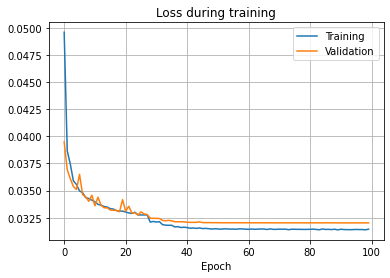

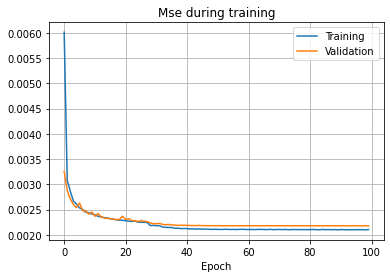

In [14]:
plot_history(history, 'loss')
plot_history(history, metric)

In [19]:
model.save_weights('unet/best_weights.hdf5')

### Model evaluation

In [7]:
model.load_weights('unet/best_weights.hdf5')

{'MSE': 0.0021717316, 'PSNR (dB)': 26.631938545333234}


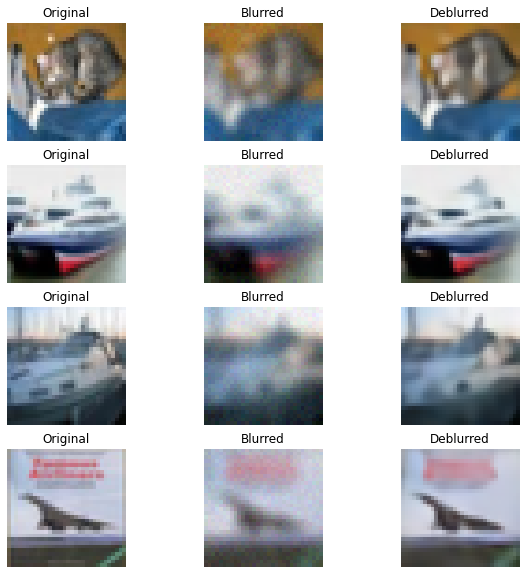

In [11]:
def evaluate_model(model, x, y, metrics):
    y_pred = model.predict(x) # Use the model to predict the output

    # Uniform the type of the array
    y_pred = y_pred.astype('float32')
    y = y.astype('float32')
    
    results = compute_metrics(y,y_pred, metrics)

    return results

def plot_results(model, n_images=4):
    y_pred = model.predict(x_test[:n_images]).astype('float32')
    plot_images([y_test, x_test, y_pred], ['Original', 'Blurred', 'Deblurred'], n_images)

def show_results(model, n_images=4):
    print(evaluate_model(model, x_test, y_test, metrics))
    plot_results(model, n_images=n_images)
    
show_results(model)

## Alternative architectures

On the success of Unet, I implemented several architectures, adapted to the constraints of this problem: the number of parameters and the image size. \
In particular, results compatible (i.e. almost the same in terms of MSE and visual aspect) with this implementation of Unet has been achieved by:
- DnCNN [[3]](https://arxiv.org/pdf/1608.03981v1.pdf): a network for estimating the residual (noise), i.e. the difference between the original image and the noisy one
- Sharp UNet [[4]](https://arxiv.org/abs/2107.12461): an intermediate layer between the skip connections add the edges of the features to the features themselves so that to sharpen them, thus, to reduce the blurring effects. This is achieved by the usage of a depthwise convolutional (non-learnable) laplacian kernel. I have also tried to initialize the kernel as laplacian and make it trainable after 20 steps, which slightly improved the results.

Apart from the architectures mentioned above, I tried to combine interesting ideas of different papers, but the results were worse or the same of Unet. At the end, I found that the current state of the art is the usage of Swin Transformers, and so I gave them a chance.

# SUnet [[5]](https://arxiv.org/pdf/2202.14009.pdf)

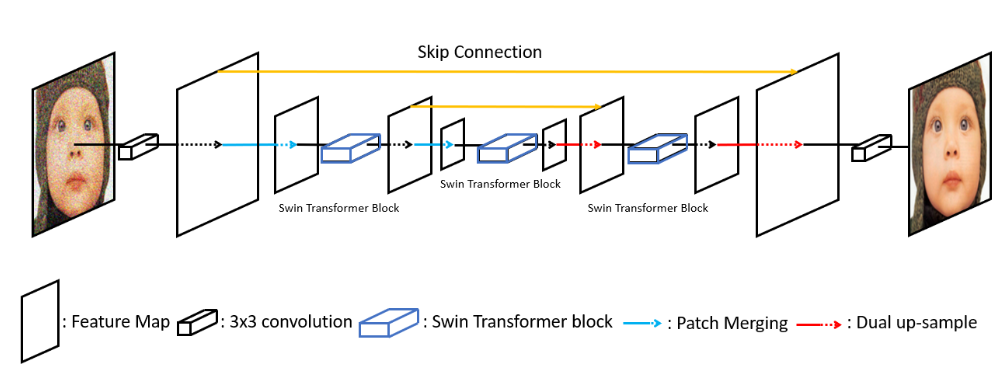

SUnet is a Unet-shaped architecture which makes use of Swin Transformers, in order to mimic the usage of different content-dependent convolutional kernels and to capture global information that cannot be (completely) acquired by deep-convolutions, since features are based on small patches. (Even if the receptive field increases as we go deeper and deeper, we perform convolutions of features coming from kernel size patches).

The network works as follows:
1. the image is projected into an "embedding space". A convolutional layer with kernel size and strides equal to a provided patch size generates C features where each pixel is a distinct representation of a patch_size x patch_size patch. In this way, pixels are independent each other, since they belongs to different patches.
2. feature maps are passed to the U-shaped model
3. a 3x3 convolutional layer project back the features in the "image space"

Step 2 is where Swin Transformers are used. The differences with the classical UNet are:
- convolutions are replaced by swin transformers
- downsampling is made through Patch merging: input features of each group of 2x2 neighboring patches are concatenated and then projected via a dense layer into a H/2*W/2 x 4*C
- dual up-sampling, introduced in the paper, is used instead of transponse convolution: it concatenate features obtained through bilinear upsampling and pixel shuffle

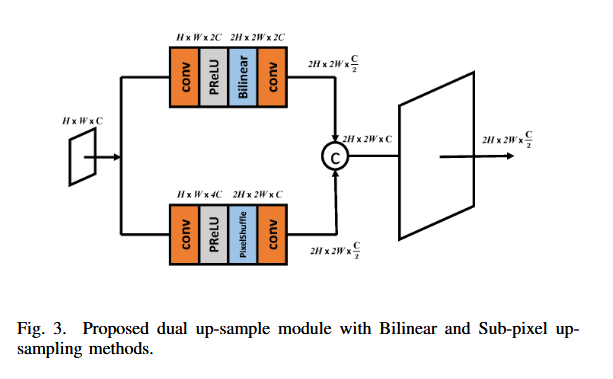

Since multi-head (self) attention (MSA) needs a sequence as input, along the whole network images are continuosly reshaped from $H x W x C$ to $H*W x C$ and viceversa

### Swin Transformer
Swin Transformer [[6]](https://arxiv.org/pdf/2103.14030.pdf) is an adaptation of the classical transformer to vision tasks. They solve two main problems:
1. Reduce the number of parameters needed for a sequence
2. Allow pixel-wise level task

They are very similar to classical transformes used in NLP, except for the fact that they make use of a 2D window-mask. A 2D attention mask (what is outside the window will be ignored) is shifted along subsequent transformers in order to "group" together different patches. Patches are then flattened along H,W axes and used in the MSA

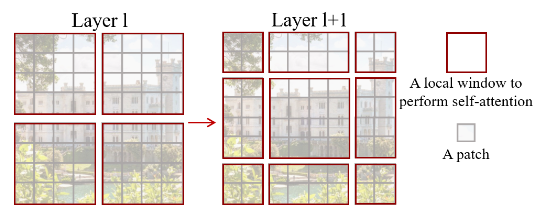

Shifting the window allows to have different sequences with different local contexts. The window is shifted in a cyclic manner, so that to always have patches of window size. As we can see from the figure below, the images are closed in a cube, so that top and bottom are neighbors, such as left and right

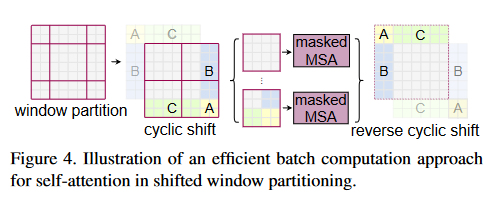

Swin transformers should always be used in block of multiples of 2, where the first one uses W-MSA (window-MSA, without shifting), and the second one uses SW-MSA (shifted-window-MSA, the window of the previous layer is shifted to top-left)

The code below has been adapted to my needs:
- Swin Transformers are taken from [[7]](https://keras.io/examples/vision/swin_transformers/) and adapted to SUnet
- SUnet code is a (partial) porting I made from Pytorch to Keras which comes from the authors of the paper's repository [[8]](https://github.com/FanChiMao/SUNet).

In particular I used a new layer known as UpsampleOut (based on Upsample) as output layer, since the original code does not allow to use a patch size different than 4. With this layer, patch size can be a multiple of 2.

### Params
- features: starting number of channels. It must be a multiple of num_heads (the number of heads in the MSA)
- patch_size: small enough
- window_size: H, W must be multiples of window_size
- depths: number of swin transformers at each layer (must be multiples of 2)
- num_heads: number of heads of the MSA

Since there are a lot of constraints and the images are very small, there is not so much tuning that can be done. The parameters below are the only one that fits with all the given constraints.
If I had not the limit on the number of learnable parameters, I could have tried different values of features, such as 72 or 96.

In [12]:
# Custom Params
features = 48 # multiple of last num_heads
patch_size = 2 # patch size should be small enough but not too much
window_size = 4 # height and width must be multiples of window_size

depths=[2, 2, 2, 2]
num_heads=[3, 6, 12, 24]
num_layers = len(depths)


input_shape = x_train.shape[1:]
img_size = input_shape[0]
img_channels = input_shape[-1]


# Paper params
# features = 96
# input_shape = (224, 224, 3)
# patch_size = 4
# window_size = 7
# img_size=224

# depths=[2, 2, 2, 2]
# num_heads=[3, 6, 12, 24]
# num_layers = len(depths)

In [13]:
# Code from https://keras.io/examples/vision/swin_transformers/
class SwinTransformer(ks.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., qkv_bias=True, dropout_rate=0.0):
        super().__init__()
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate
        
        # if window size is larger than input resolution, we don't partition windows
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must be in [0, window_size)"
        
        self.norm1 = ks.layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size),
            num_heads=num_heads, qkv_bias=qkv_bias
        )
#         self.drop_path = DropPath(dropout_rate)
        
        # ---- skip connection -----
        
        self.norm2 = ks.layers.LayerNormalization(epsilon=1e-5)
        num_mlp = int(dim * mlp_ratio)
        self.mlp = ks.Sequential(
            [
                ks.layers.Dense(num_mlp),
                ks.layers.Activation(ks.activations.gelu),
                ks.layers.Dropout(dropout_rate),
                ks.layers.Dense(dim),
                ks.layers.Dropout(dropout_rate),
            ]
        )

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.input_resolution
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape=[-1, self.window_size * self.window_size]) # 2D to token
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.input_resolution
        _, num_patches_before, channels = x.shape
        
        assert num_patches_before == height * width, f"input feature has wrong size: {num_patches_before} != {height} * {width}"
        
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels)) # token to 2D
        
        # cyclic shift: top, left
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
        
        # partition windows (get a list of patches)
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape=(-1, self.window_size * self.window_size, channels)) # img to token
        
        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows (merge patches to get back the whole image)
        attn_windows = tf.reshape(attn_windows, shape=(-1, self.window_size, self.window_size, channels)) # token to img
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)
        
        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))  # img to token
#         x = self.drop_path(x)
        
        x = x_skip + x
        
        x_skip = x        
        x = self.norm2(x)
        x = self.mlp(x)
#         x = self.drop_path(x)
        
        x = x_skip + x
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'shift_size': self.shift_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

class WindowAttention(ks.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.dropout_rate = dropout_rate
        
        self.scale = (dim // num_heads) ** -0.5
        
        self.qkv = ks.layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = ks.layers.Dropout(dropout_rate)
        self.proj = ks.layers.Dense(dim)

    def build(self, input_shape):
        # (2M −1)×(2M −1) Bias table (learnable)
        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
            name='relative_position_bias_table'
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1) # relative positions from top_right corner   

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads # (head_dim is dk in the paper)
        
        # qkv projection
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        
        # --- masked scaled dot-product + Bias ---
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k # (Q K^t / sqrt(dk))   ---  batch_size x num_heads x size x size 
        
        # add bias B from relative_position_bias_table
        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape=(-1,))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape=(num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0) # add bias to scaled-dot product
        
        # weights = softmax(QK^T/sqrt(dk) + B), where the input of softmax is masked
        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), ks.backend.floatx()) # 1 x nW x 1 x ...
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size)) # None x nW x num_heads x size x size 
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size)) # batch_size x num_heads x size x size 
            attn = ks.activations.softmax(attn, axis=-1)
        else:
            attn = ks.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        # attention(Q,K,V) = softmax( QK^T/sqrt(dk) + B) V
        x_qkv = attn @ v                                        # batch_size x num_heads x size x head_dim (dk)
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))          # batch_size x size x num_heads x dk
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))   # batch_size x size x channels (=num_heads * dk)
        x_qkv = self.proj(x_qkv)                                # batch_size x size x dim (dim and channels should be equal)
        x_qkv = self.dropout(x_qkv)
        return x_qkv
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'window_size': self.window_size,
            'num_heads': self.num_heads,
            'qkv_bias': self.qkv_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

# Helpers
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    n_patch_y = height // window_size
    n_patch_x = width // window_size
    
    x = tf.reshape(x, shape=(-1, n_patch_y, window_size, n_patch_x, window_size, channels)) # _ x n_y x win_size x n_x x win_size x C
    # "aggregate" patches into a list of patches
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5)) # _ x n_y x n_x x win_size x win_size x C
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels)) # __ x win_size x win_size x C
    return windows

def window_reverse(windows, window_size, height, width, channels):
    assert height % window_size == 0 and width % window_size == 0, f"{height} and {width} must be multiples of {window_size}"
    n_patch_y = height // window_size
    n_patch_x = width // window_size
    x = tf.reshape(windows, shape=(-1, n_patch_y, n_patch_x, window_size, window_size, channels))
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x

# https://paperswithcode.com/method/droppath
class DropPath(ks.layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1) # batch_size, 1, 1, 1
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [14]:
class PatchEmbed(ks.layers.Layer):
    def __init__(self, img_size=32, patch_size=4, embed_dim=96, **kwargs):
        super(PatchEmbed, self).__init__(**kwargs)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        self.proj = ks.layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        
        res = img_size // patch_size
        self.patches_resolution = (res, res)
        self.num_patches = res * res
        
    def call(self, x):
        b, h, w, c = x.shape
        
        x = self.proj(x)
        ph, pw = x.shape[1:-1]
        x = tf.reshape(x, shape=(-1, ph*pw, c))
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'img_size': self.img_size,
            'patch_size':self.patch_size,
            'embed_dim': self.embed_dim,
        })
        return config
        
class BasicLayer(ks.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4, qkv_bias=True, downsample=True, **kwargs):
        super(BasicLayer, self).__init__(**kwargs)
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.downsample = downsample
        
        self.blocks = [SwinTransformer(dim=dim, input_resolution=input_resolution,
                                            num_heads=num_heads, window_size=window_size,
                                            shift_size=0 if (i % 2 == 0) else window_size // 2, # alternate W_MSA and SW-MSA
                                            mlp_ratio=mlp_ratio, qkv_bias=qkv_bias)
                       for i in range(depth)]
        
        if downsample:
            self.downsample_l = PatchMerging(input_resolution, dim=dim)
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
#             print(x.shape)
        
        if self.downsample:
            x = self.downsample_l(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'depth': self.depth,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'downsample': self.downsample,
        })
        return config
    
class BasicLayerUp(ks.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4, qkv_bias=True, upsample=True, **kwargs):
        super(BasicLayerUp, self).__init__(**kwargs)
        
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.upsample = upsample
        
        self.blocks = [SwinTransformer(dim=dim, input_resolution=input_resolution,
                                            num_heads=num_heads, window_size=window_size,
                                            shift_size=0 if (i % 2 == 0) else window_size // 2,
                                            mlp_ratio=mlp_ratio, qkv_bias=qkv_bias)
                       for i in range(depth)]
        
        if upsample:
            self.upsample_l = UpSample(input_resolution, in_channels=dim, scale_factor=2)
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        
        if self.upsample:
            x = self.upsample_l(x)
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'depth': self.depth,
            'num_heads': self.num_heads,
            'window_size': self.window_size,
            'mlp_ratio': self.mlp_ratio,
            'qkv_bias': self.qkv_bias,
            'upsample': self.upsample,
        })
        return config

class PatchMerging(ks.layers.Layer):
    def __init__(self, input_resolution, dim, **kwargs):
        super(PatchMerging, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.dim = dim
        
        self.norm = ks.layers.LayerNormalization(epsilon=1e-5)
        self.reduction = ks.layers.Dense(2 * dim, use_bias=False)
        
    def call(self, x):
        h, w = self.input_resolution
        b, l, c = x.shape
        
        assert l == h * w, "input feature has wrong size"
        assert h % 2 == 0 and w % 2 == 0, f"x size ({h}*{w}) are not even." 
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        
        x = tf.reshape(x, shape=(-1, h*w//4, 4 * c))  # B H/2*W/2 4*C
        
        x = self.norm(x)
        x = self.reduction(x)
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'dim': self.dim,
        })
        return config
    
class PixelShuffle(ks.layers.Layer):
    def __init__(self, upscale_factor, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.upscale_factor = upscale_factor
    
    def call(self, x):
        return tf.nn.depth_to_space(x, self.upscale_factor)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'upscale_factor': self.upscale_factor,
        })
        return config

class UpSample(ks.layers.Layer):
    def __init__(self, input_resolution, in_channels, scale_factor, **kwargs):
        super(UpSample, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.in_channels = in_channels
        self.scale_factor = scale_factor
        
        if self.scale_factor == 2:
            self.conv = ks.layers.Conv2D(in_channels//2, kernel_size=(1,1), use_bias=False)
            self.up_p = ks.Sequential([ks.layers.Conv2D(2*in_channels, kernel_size=(1,1), use_bias=False),
                                       ks.layers.PReLU(),
                                       PixelShuffle(scale_factor),
                                       ks.layers.Conv2D(in_channels//2, kernel_size=(1,1), use_bias=False)])

            self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                       ks.layers.PReLU(),
                                       ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                       ks.layers.Conv2D(in_channels // 2, kernel_size=(1,1), use_bias=False)])
        elif self.scale_factor == 4:            
            self.conv = ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)
            self.up_p = ks.Sequential([ks.layers.Conv2D(16*in_channels, kernel_size=(1,1), use_bias=False),
                                       ks.layers.PReLU(),
                                       PixelShuffle(scale_factor),
                                       ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])

            self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                       ks.layers.PReLU(),
                                       ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                       ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])
        
    def call(self, x):
        if type(self.input_resolution) == int:
            h = self.input_resolution
            w = self.input_resolution

        elif type(self.input_resolution) == tuple:
            h, w = self.input_resolution
            
        b, l, c = x.shape
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        x_p = self.up_p(x) # pixel shuffle
        x_b = self.up_b(x) # bilinear
        
        x = ks.layers.concatenate([x_p, x_b])
        x = self.conv(x)
        
        if self.scale_factor == 2:
            c = c//2            
            x = tf.reshape(x, shape=(-1, h*w*4, c))        
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'in_channels': self.in_channels,
            'scale_factor': self.scale_factor,
        })
        return config
    
class UpSampleOut(ks.layers.Layer):
    def __init__(self, input_resolution, in_channels, scale_factor, **kwargs):
        super(UpSampleOut, self).__init__(**kwargs)
        
        self.input_resolution = input_resolution
        self.in_channels = in_channels
        self.scale_factor = scale_factor
        
        self.conv = ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)
        self.up_p = ks.Sequential([ks.layers.Conv2D((scale_factor**2)*in_channels, kernel_size=(1,1), use_bias=False),
                                   ks.layers.PReLU(),
                                   PixelShuffle(scale_factor),
                                   ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])

        self.up_b = ks.Sequential([ks.layers.Conv2D(in_channels, kernel_size=(1,1)),
                                   ks.layers.PReLU(),
                                   ks.layers.UpSampling2D(size=scale_factor, interpolation='bilinear'),
                                   ks.layers.Conv2D(in_channels, kernel_size=(1,1), use_bias=False)])
        
    def call(self, x):
        if type(self.input_resolution) == int:
            h = self.input_resolution
            w = self.input_resolution

        elif type(self.input_resolution) == tuple:
            h, w = self.input_resolution
            
        b, l, c = x.shape
        
        x = tf.reshape(x, shape=(-1, h, w, c))
        x_p = self.up_p(x) # pixel shuffle
        x_b = self.up_b(x) # bilinear
        
        x = ks.layers.concatenate([x_p, x_b])
        x = self.conv(x)      
        
        return x
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'input_resolution': self.input_resolution,
            'in_channels': self.in_channels,
            'scale_factor': self.scale_factor,
        })
        return config
    
def forward_features(x):    
    patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, embed_dim=features)
    down_layers = []
    for i in range(num_layers):
        layer = BasicLayer(dim=features * 2 ** i,
                           input_resolution = (patch_embed.patches_resolution[0] // (2 ** i),
                                               patch_embed.patches_resolution[1] // (2 ** i)),
                           depth = depths[i],
                           num_heads = num_heads[i],
                           window_size = window_size,
                           downsample=i<num_layers-1)
        down_layers.append(layer)
    norm = ks.layers.LayerNormalization(epsilon=1e-5)
    
    
    residual = x
    x = patch_embed(x)
    x_downsample = []
    for layer in down_layers:
        x_downsample.append(x)
        x = layer(x)

    x = norm(x)
    
    return x, residual, x_downsample, patch_embed.patches_resolution

def forward_up_features(x, x_downsample, patches_resolution):
    up_layers = [
        UpSample(input_resolution=patches_resolution[0] // (2 ** (num_layers - 1)),
                 in_channels=int(features * 2 ** (num_layers - 1)), scale_factor=2)
    ]
    project_back = []
    for i in range(1, num_layers):        
        layer = BasicLayerUp(dim=int(features * 2 ** (num_layers - 1 - i)),
                           input_resolution = (patches_resolution[0] // (2 ** (num_layers - 1 - i)),
                                               patches_resolution[1] // (2 ** (num_layers - 1 - i))),
                           depth = depths[num_layers - 1 - i],
                           num_heads = num_heads[num_layers - 1 - i],
                           window_size = window_size,
                           upsample=i<num_layers-1)
        up_layers.append(layer)        
        project_back.append(ks.layers.Dense(int(features * 2 ** (num_layers - 1 - i))))
    
    norm_up = ks.layers.LayerNormalization(epsilon=1e-5)
    
    layer = up_layers.pop(0)
    x = layer(x)
    for i, layer in enumerate(up_layers):
        x = tf.concat([x, x_downsample[2 - i]], -1)  # concat last dimension
        x = project_back[i](x)
        x = layer(x)

    x = norm_up(x)  # B L C
    
    return x

def up_to_img_size(x, patches_resolution):
    h, w = patches_resolution
    b, l, c = x.shape
    assert l == h * w, "input features has wrong size"
    
    # probably a bug in the code. In this way, I can upscale whatever is the initial patch_size and not only for patch_size=4
#     up = UpSample(input_resolution=(img_size // patch_size, img_size // patch_size), in_channels=features, scale_factor=4)
    up = UpSampleOut(input_resolution=(img_size // patch_size, img_size // patch_size), in_channels=features, scale_factor=patch_size)
    x = up(x)

    return x


def create_sunet():
    input = ks.layers.Input(shape=input_shape)
    
    # f_shallow
    x = ks.layers.Conv2D(features, kernel_size=(3,3), padding='same')(input)

    
    # f_deep
    x, residual, x_downsample, patches_resolution = forward_features(x)
    x = forward_up_features(x, x_downsample, patches_resolution)
    x = up_to_img_size(x, patches_resolution)

    
    # out
    out = ks.layers.Conv2D(img_channels, kernel_size=(3,3), padding='same')(x)
    
    return ks.Model(input, out)

In [15]:
model = create_sunet()


print(count_trainable_params(model))
model.summary()

7330695
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 48)   1344        ['input_2[0][0]']                
                                                                                                  
 patch_embed (PatchEmbed)       (None, 256, 48)      9264        ['conv2d_19[0][0]']              
                                                                                                  
 basic_layer (BasicLayer)       (None, 64, 96)       80262       ['patch_embed[0][0]']            
                                                                                    

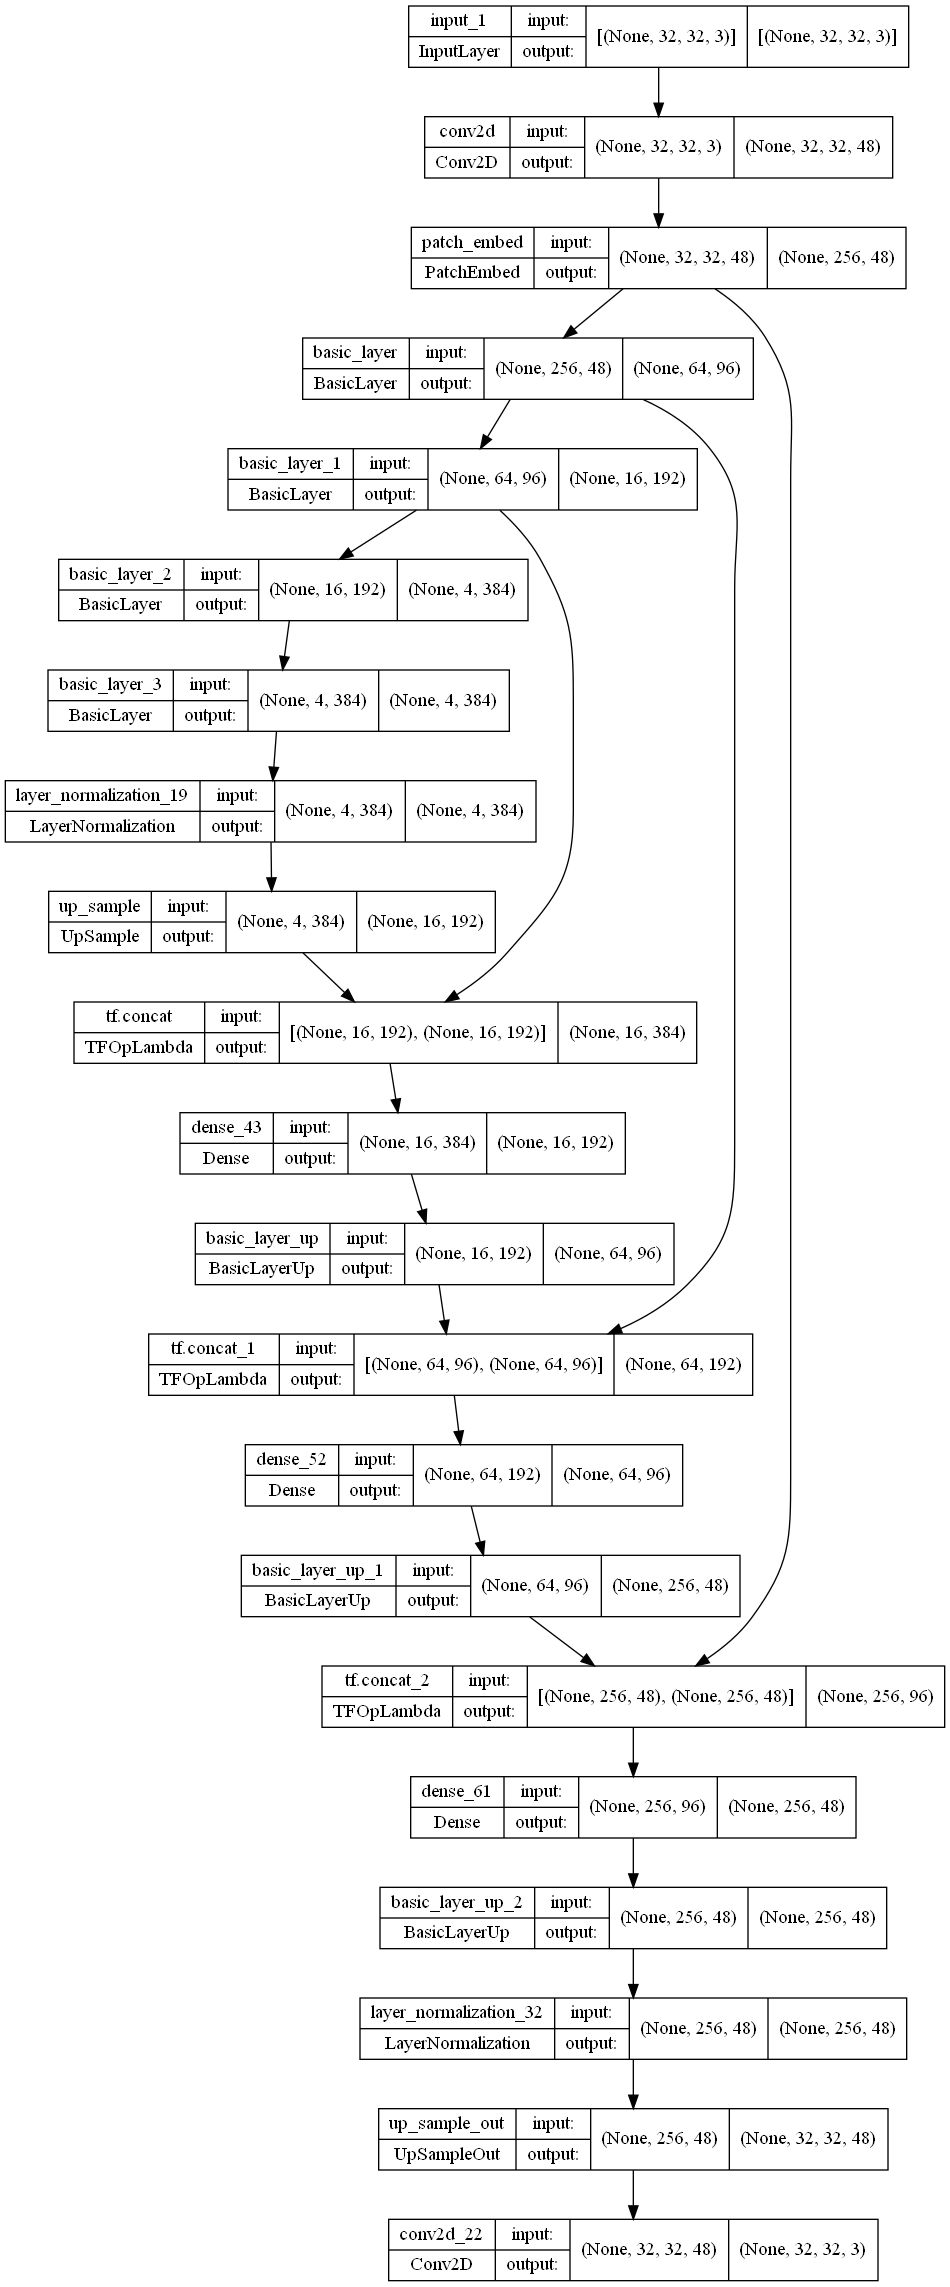

In [8]:
ks.utils.plot_model(model=model, to_file='unet.png', show_shapes=True)

In [ ]:
# I recreate the dataset, since it depends from the batch_size and also because both the model cannot be trained
# without restarting the kernel. Otherwise, 90% of the time the second training will stop for exhaust of GPU memory

batch_size = 64

train_ds = tf_data_generator(x_train, y_train, batch_size, augmentations=[horizontal_flip, vertical_flip, rotate])
val_ds = tf_data_generator(x_val, y_val, batch_size)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

working_dir = 'sunet'
loss = 'mae'
lr = 1e-3
epochs = 1000
monitor = f'val_{metric}'
# WARNING: > 1.2 makes PC freeze cause of exhausting of memory
steps_per_epoch = 1.2 * len(x_train) // batch_size

early_stopping_callback = ks.callbacks.EarlyStopping(monitor=monitor, patience=40, verbose=1, mode='auto')
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', min_lr=1e-5, factor=0.5, patience=5, verbose=1, mode='min')

checkpoint_dir = os.path.join(working_dir, 'ckpt')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_filepath = os.path.join(checkpoint_dir, 'weights_{epoch:02d}-{val_loss:.2f}.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor=monitor,
    mode='min',
    save_weights_only=True,
    save_best_only=True)

backup_dir = os.path.join(working_dir, 'backup')
backup_callback = ks.callbacks.BackupAndRestore(backup_dir=backup_dir)

log_dir = os.path.join(working_dir, 'tensorboard-logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callback,
    backup_callback,
    model_checkpoint_callback,
#     tensorboard_callback
]

# Classical Transformers hyperparameters 
optimizer = ks.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# ks.backend.clear_session()
history = model.fit(train_ds, validation_data=val_ds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/1000
843/843 [==============================] - 82s 80ms/step - loss: 0.0744 - mse: 0.0142 - val_loss: 0.0482 - val_mse: 0.0046 - lr: 0.0010
Epoch 2/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0444 - mse: 0.0040 - val_loss: 0.0401 - val_mse: 0.0033 - lr: 0.0010
Epoch 3/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0391 - mse: 0.0031 - val_loss: 0.0374 - val_mse: 0.0029 - lr: 0.0010
Epoch 4/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0372 - mse: 0.0028 - val_loss: 0.0365 - val_mse: 0.0027 - lr: 0.0010
Epoch 5/1000
843/843 [==============================] - 66s 78ms/step - loss: 0.0360 - mse: 0.0027 - val_loss: 0.0363 - val_mse: 0.0026 - lr: 0.0010
Epoch 6/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0354 - mse: 0.0026 - val_loss: 0.0348 - val_mse: 0.0025 - lr: 0.0010
Epoch 7/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0349 - mse: 0.0025 - val_l

Epoch 56/1000
843/843 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0020
Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
843/843 [==============================] - 66s 78ms/step - loss: 0.0309 - mse: 0.0020 - val_loss: 0.0320 - val_mse: 0.0022 - lr: 0.0010
Epoch 57/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0305 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 58/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0304 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 59/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0303 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 60/1000
843/843 [==============================] - 65s 77ms/step - loss: 0.0304 - mse: 0.0020 - val_loss: 0.0314 - val_mse: 0.0021 - lr: 5.0000e-04
Epoch 61/1000
843/843 [==============================] - 65s 77ms/step - loss

### Training results

Giving a look to the loss and mse plot during training, we can see that:
1. the gradient is very stable
2. after the 80-th epoch, it stops improving
3. the model tends to (very slight) overfits after 50-60 epochs

Therefore, I load weights of the 58-th epoch.

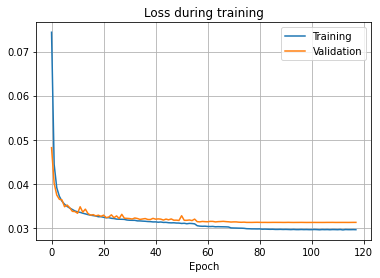

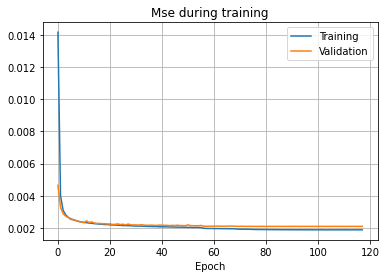

In [12]:
plot_history(history, 'loss')
plot_history(history, metric)

### Model evaluation

{'MSE': 0.0020762281, 'PSNR (dB)': 26.82724943562885}


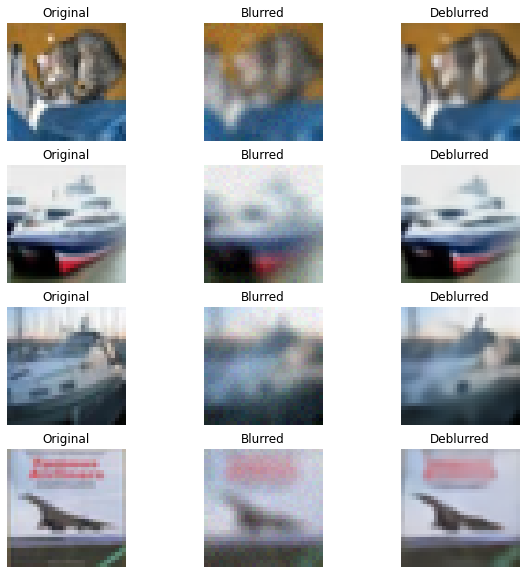

In [17]:
model.load_weights('sunet/ckpt/weights_78-0.03.hdf5')
show_results(model)

In [14]:
evaluate_model(model, x_test,  y_test, {'MSE': mse, 'PSNR (dB)': psnr})

{'MSE': 0.002081362, 'PSNR (dB)': 26.816523662397653}

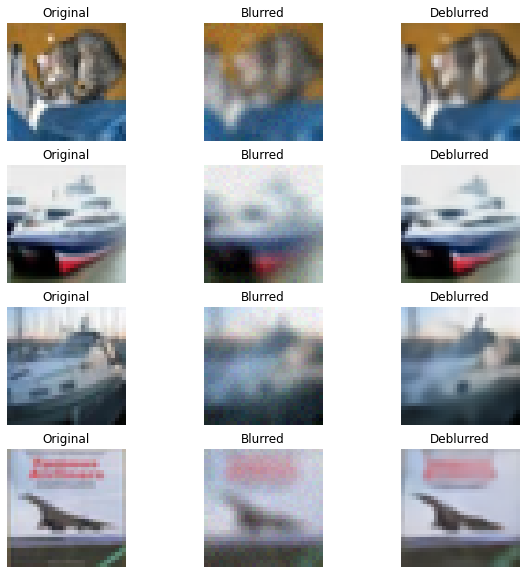

In [19]:
n_images = 4
y_pred = model.predict(x_test[:n_images]).astype('float32')
plot_images([y_test, x_test, y_pred], ['Original', 'Blurred', 'Deblurred'], n_images)

## Results
Although the PSNR and the MSE are both improved using SUnet, probably, considering that the images are small, this architecture is a bit overkill. I decided to keep it in the report because it is the SOTA and the number of parameters is not higher than the classical Unet.

Thus, the best model according to MSE is SUnet.